In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from assimilation_schemes import OI

plt.style.use('seaborn')

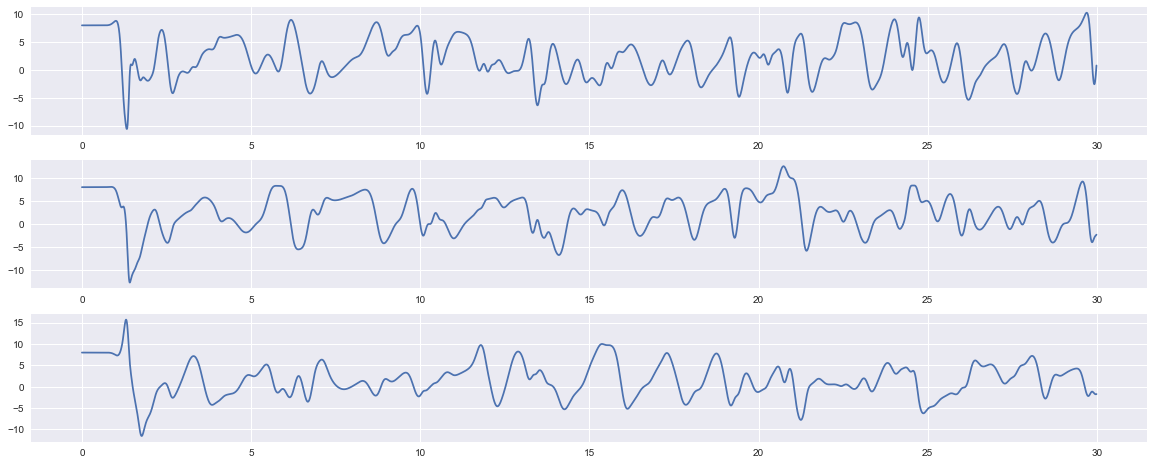

In [2]:
def lorenz96_fdm(ts, x0, F=8):
    dt = ts[1] - ts[0]
    x = np.zeros((x0.size, ts.size))
    x[:,0] = x0.ravel()
    
    for idx, time in enumerate(ts[1:]):
        xn = x[:,idx]
        xn_p1 = np.roll(xn, -1)  # x_{n+1}
        xn_m1 = np.roll(xn, 1)  # x_{n-1}
        xn_m2 = np.roll(xn, 2)  # x_{n-2}
        x[:,idx+1] = xn + dt * ((xn_p1-xn_m2) * xn_m1 - xn + F)
        
    return x

F = 8
ts = np.arange(0, 30, 0.01)
x0 = np.ones(40) * F
x0[19] += 0.01
X = lorenz96_fdm(ts, x0, F)

fig, axs = plt.subplots(nrows=3, figsize=(20, 8))
axs[0].plot(ts, X[0,:])
axs[1].plot(ts, X[1,:])
axs[2].plot(ts, X[2,:])

### Nature Run

In [3]:
seed = 42
rng = np.random.RandomState(seed)

N = 40  # number of variables
X_ini = rng.randint(0, 10, size=N)
X_ini

array([6, 3, 7, 4, 6, 9, 2, 6, 7, 4, 3, 7, 7, 2, 5, 4, 1, 7, 5, 1, 4, 0,
       9, 5, 8, 0, 9, 2, 6, 3, 8, 2, 4, 2, 6, 4, 8, 6, 1, 3])

In [4]:
F = 8
time = 30
dt = 0.01
ts = np.arange(0, time, dt)
X_nature = lorenz96_fdm(ts, X_ini, F)

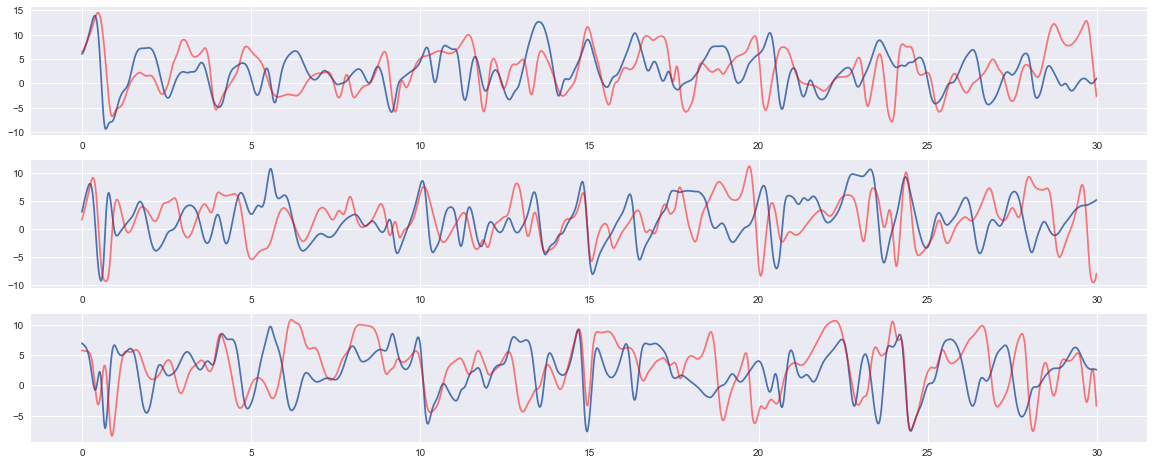

In [5]:
#X_perturb_ini = X_ini + rng.rand(N) * 0.1
X_perturb_ini = X_ini + np.random.normal(0, 1, size=X_ini.size)
X_perturb = lorenz96_fdm(ts, X_perturb_ini, F)

fig, axs = plt.subplots(nrows=3, figsize=(20, 8))
for i in range(3):
    axs[i].plot(ts, X_nature[i,:])
    axs[i].plot(ts, X_perturb[i,:], color='red', alpha=0.5)

### Initial condition

In [6]:
X_ni = X_perturb[:,30]
X_ini

array([6, 3, 7, 4, 6, 9, 2, 6, 7, 4, 3, 7, 7, 2, 5, 4, 1, 7, 5, 1, 4, 0,
       9, 5, 8, 0, 9, 2, 6, 3, 8, 2, 4, 2, 6, 4, 8, 6, 1, 3])

### Simulated Obs

In [7]:
def gen_random_normal(mean, var, size, random_state=None):
    """
    Generate random gaussian distribution numbers
    
    Parameters:
    ----------
    mean, var: scaler or array-like.
        If array-like, its length should equal to 'size'.
    size: int
        The amount of random numbers.
    random_state: int
        If None, np.random.randint(0, 99) will be used.
        
    Return:
    ------
    An 1d array of random numbers.
    """
    if random_state is None:
        random_state = np.random.randint(0, 99)
        
    mean = np.array(mean)
    var = np.array(var)
    
    rng = np.random.RandomState(random_state)
    result = rng.randn(max(mean.size, var.size, size))
    result = (result + mean) * np.sqrt(var)
    return result

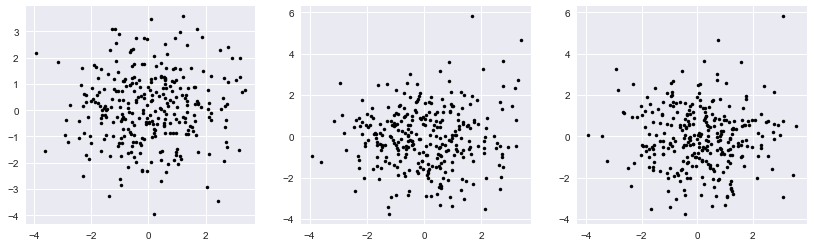

In [22]:
# observation parameters for each variables
obs_mean = [0 for i in range(N)]
obs_var = [2 for i in range(N)]
random_state = [i for i in range(N)]

# assimilate observation parameters
obs_timeintv = 0.1
cycle_num = int(time / obs_timeintv)

# construct observation error
X_obs_err = np.zeros((N, cycle_num))
for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
    X_obs_err[irow,:] = gen_random_normal(obsm, obsv, cycle_num, rst)
    
X_obs = X_nature[:,::int(obs_timeintv/dt)] + X_obs_err

# plot observation errors
fig, axs = plt.subplots(figsize=(14, 4), nrows=1, ncols=3)
axs[0].plot(X_obs_err[0], X_obs_err[1], 'k.')
axs[1].plot(X_obs_err[0], X_obs_err[2], 'k.')
axs[2].plot(X_obs_err[1], X_obs_err[2], 'k.')

### NMC

In [23]:
def nmc(model, ref, dt, alpha, t1, t2, num):
    result = np.zeros((num, 2, ref[:,0].size))
    interv = int((t2-t1) / dt)
    for n in range(num):
        x0 = ref[:,n*interv]
        ts = np.arange(0, t2, dt)
        xs = model(ts, x0)
        result[n,0,:] = xs[:,int(t1/dt)]
        result[n,1,:] = xs[:,-1]

    Pb = np.zeros((x0.size, x0.size))
    for n in range(1, num):
        xf_diff = result[n,0,:] - result[n-1,1,:]
        Pb += xf_diff[:,np.newaxis] * xf_diff
        
    return alpha * Pb / num

In [24]:
R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)
Pb = nmc(lorenz96_fdm, X_nature, dt, alpha=50, t1=0.2, t2=0.4, num=20)
Pb

array([[ 4.78793783, -0.88921432,  2.62773618, ..., -0.69567011,
        -1.15010688,  0.62656627],
       [-0.88921432,  3.09171635, -0.95810599, ..., -0.14967659,
         0.13989073, -0.96524011],
       [ 2.62773618, -0.95810599,  4.6850505 , ...,  0.24152888,
        -1.4871303 , -0.4421061 ],
       ...,
       [-0.69567011, -0.14967659,  0.24152888, ...,  1.16985333,
        -0.32808261, -0.8038874 ],
       [-1.15010688,  0.13989073, -1.4871303 , ..., -0.32808261,
         1.56054949,  0.42757896],
       [ 0.62656627, -0.96524011, -0.4421061 , ..., -0.8038874 ,
         0.42757896,  2.23205245]])

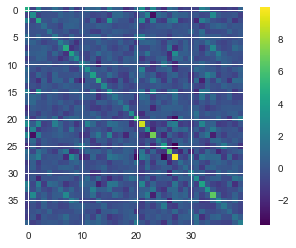

In [25]:
plt.imshow(Pb, cmap='viridis', interpolation='nearest')
plt.colorbar();

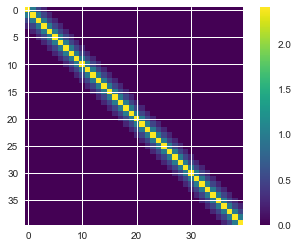

In [26]:
Pb = R * 1.2
Pb += np.diag(1*np.ones(N-1), k=1) + np.diag(1*np.ones(N-1), k=-1)
Pb += np.diag(0.5*np.ones(N-2), k=2) + np.diag(0.5*np.ones(N-2), k=-2)
Pb += np.diag(0.25*np.ones(N-3), k=3) + np.diag(0.25*np.ones(N-3), k=-3)

plt.imshow(Pb, cmap='viridis', interpolation='nearest')
plt.colorbar();

========Some Parameters=========
cycle length (time interval between two observations): 0.1 sec
number of cycle: 300
dt = 0.01 sec
initial value for experiment: [6 3 7 4 6 9 2 6 7 4 3 7 7 2 5 4 1 7 5 1 4 0 9 5 8 0 9 2 6 3 8 2 4 2 6 4 8
 6 1 3]
initial value for nature run: [6. 3. 7. 4. 6. 9. 2. 6. 7. 4. 3. 7. 7. 2. 5. 4. 1. 7. 5. 1. 4. 0. 9. 5.
 8. 0. 9. 2. 6. 3. 8. 2. 4. 2. 6. 4. 8. 6. 1. 3.]


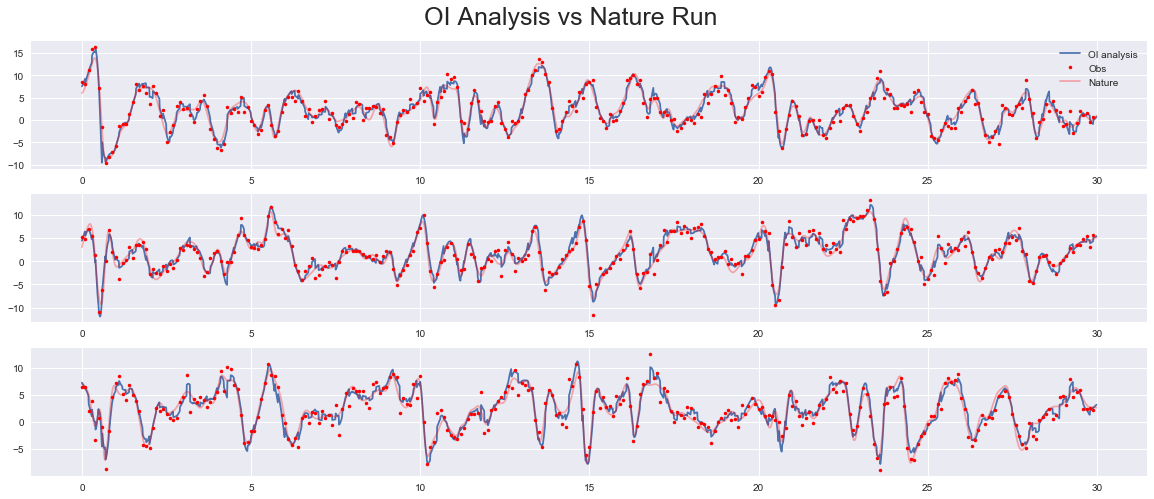

In [27]:
from assimilation_schemes import OI


print('========Some Parameters=========')
print(f'cycle length (time interval between two observations): {obs_timeintv} sec')
print(f'number of cycle: {cycle_num}')
print(f'dt = {dt} sec')
print(f'initial value for experiment: {X_ini.ravel()}')
print(f'initial value for nature run: {X_nature[:,0]}')
print('=================================')


cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
xb = xb[:,np.newaxis]  # convert to column vector
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

# start cycle assimilation
for nc in range(cycle_num):
    # calculate analysis field, then forecast
    xa = OI(xb, X_obs[:,[nc]], Pb, R)[0]
    x = lorenz96_fdm(ts, xa.ravel())
    result[:,nc*int(cycle_len/dt):(nc+1)*int(cycle_len/dt)] = x
        
    # for next cycle
    xb = x[:,[-1]]
    t_start = int(ts[-1] + dt)
    ts = np.arange(t_start, t_start+cycle_len, dt)
    
    
# plot assimilation result
ts = np.arange(0, time, dt)
t_obs = np.arange(0, time, obs_timeintv)

fig2, axs = plt.subplots(nrows=3, figsize=(20, 8))
for i in range(3):
    axs[i].plot(ts, result[i,:], label='OI analysis')
    axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
    axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
axs[0].legend()

fig2.suptitle('OI Analysis vs Nature Run', fontsize=25, y=0.94);

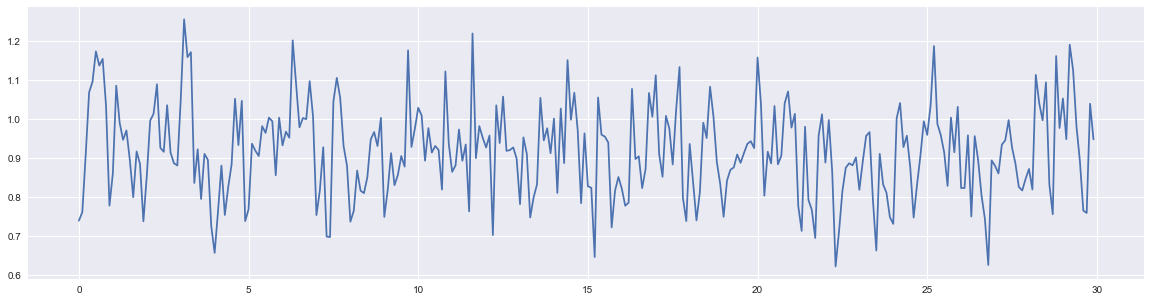

In [28]:
rmse = np.sqrt(np.mean((result-X_nature)**2, axis=0))
plt.figure(figsize=(20, 5))
plt.plot(ts[::int(obs_timeintv/dt)], rmse[::int(obs_timeintv/dt)])